## Eliza's proposed method for computing the derivative

In [1]:
import numpy as np
from scipy.stats import special_ortho_group
import jax.numpy as jnp
from jax import grad, vmap
from Mondrian_forest import *
from sklearn.metrics import mean_squared_error
from numpy.linalg import norm
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd
import pickle

dim_in = 5
active = 3
def simulate_y(x, rotation, seed = 0, noise_sig2 = 0.0001):
    res = jnp.dot(x, rotation)
    projected = jnp.concatenate([jnp.ones(active), jnp.zeros(dim_in - active)])
    y = jnp.dot(res ** 4, projected)
    r_noise = np.random.RandomState(seed)
    #n = len(x)
    noise = r_noise.randn(1)[0] * jnp.sqrt(noise_sig2)
    y = y + noise
    return y


n = 3200
x_train_, y_train_, x_test, y_test, rotation = pickle.load(open('data.pickle', 'rb'))
x_train = np.random.rand(n - 2000,dim_in)*2 - 1
y_train = simulate_y(x_train, rotation)

x_train = np.concatenate([x_train_, x_train], axis = 0)
y_train = np.concatenate([y_train_, y_train])

x_test = x_test[:500]
y_test = y_test[:500]

sample_range = [100, 200, 400, 800, 1600, 3200]

M = 20                      # number of Mondrian trees to use
delta = 0                   # ridge regression delta

100%|██████████| 1/1 [08:04<00:00, 484.24s/it]

min mse: 0.19414798170372216
time: 2.9951165240420248


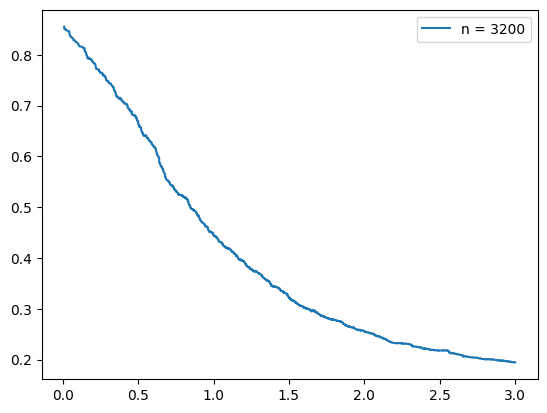

In [4]:
lifetime_max = 3
for n_sim in tqdm([3200]):
    results = evaluate_all_lifetimes(x_train[:n_sim, ], y_train[:n_sim], x_test, y_test, M, lifetime_max, delta)
    print("min mse: " + str(min(results['mse'])))
    print("time: " + str(results['times'][np.where(results['mse'] == min(results['mse']))[0][0]]))
    plt.plot(results['times'], results['mse'], label = 'n = ' + str(n_sim))
    plt.legend()

## Iteratively Reapplying H to transform data

In [ ]:
from Mondrian_forest import estimate_H

stats = {}
lifetime_max = 1.8
iterations = 8
decrement = 0
beam_width = 3
for n_sim in [2000]:
    stats[n_sim] = []
    #print(f"number of training samples: {n_sim}")
    for index in range(5):
        explore = []
        exploit = []
        results = {'full': [], 'partial': []}
        mse, X_bd_all, X, history, y_hat_train = train_and_evaluate(
            x_train[:n_sim, ], y_train[:n_sim], x_test, y_test, M, lifetime_max, delta)

        exploit.append((np.identity(dim_in), mse, lifetime_max))
        H_0 = estimate_H(x_train[:n_sim, ], y_train[:n_sim], X_bd_all, M, X, history, delta, y_hat_train)
        H_0 = H_0 / two_one_norm(H_0)
        #print(f"mse before:{mse:.5f}")
        #print("full")
        results['full'].append(mse)
        x_train_transformed, x_test_transformed = transform_data(H_0, x_train[:n_sim, ], x_test)
        lifetime = lifetime_max
        explore.append(H_0)
        for reiterate in range(iterations):

            lifetime -= decrement
            new_beam = exploit.copy()

            for H in explore:
                x_train_transformed, x_test_transformed = transform_data(H, x_train[:n_sim, ], x_test)
                mse_temp, _, _, _, _, _ = train_and_evaluate(x_train_transformed, y_train[:n_sim], 
                                                                x_test_transformed, y_test, M, lifetime, delta)
                new_beam.append((H, mse_temp, lifetime))
            explore = []

            #print(get_angle_distance(H, true_H))
            for H, mse, _ in exploit:
                x_train_transformed, x_test_transformed = transform_data(H, x_train[:n_sim, ], x_test)
                for round in range(beam_width):
                    mse_temp, H_temp = experiment(x_train_transformed, y_train[:n_sim],
                                                x_test_transformed, y_test, M, lifetime, delta, H)
                    new_beam.append((H, mse_temp, lifetime))
                    explore.append(H_temp)

            new_beam.sort(key=lambda x: x[1])
            exploit = new_beam[:beam_width]
            
            mse = exploit[0][1]
            #print(f'mse: {exploit[0][1]:.5f}, lifetime: {exploit[0][2]:.2f}')
            results['full'].append(mse)
        stats[n_sim].append(results)